In [4]:
import pandas as pd
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, reweight_laplace
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')

In [5]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=0)

array([3.04470101, 0.63298709, 0.65432751, 1.5175129 , 0.78085325,
       0.6341433 , 0.87459994, 1.00571173, 0.68504912, 1.01402755,
       0.63915968, 0.65825195, 0.66197261, 1.04407087, 2.80167096,
       0.80280225, 0.83361601, 0.67170434, 0.66538914, 0.48316792,
       0.5704564 , 0.52324962, 1.10463661, 1.22121747, 0.52581269,
       0.58765684, 0.50016525, 3.22377082, 0.69175819, 1.20546935,
       4.12656194, 0.67824499, 1.75265207, 2.67871074, 1.18177785,
       1.11429053, 0.44422598, 0.63481357, 0.87829422, 0.30881013,
       1.04058779, 0.68213382, 0.38948335, 0.74921793, 0.97165063,
       1.27478184, 0.9820337 , 0.50643875, 0.39695896, 0.53155178,
       1.06668606, 1.25653031, 0.60235276, 0.41815181, 1.51938207,
       0.82304881, 0.99505599, 0.47844257, 0.57760229, 1.59708697,
       0.55656234, 0.52596506])

In [6]:
# compartment parameters
N = 100
C = 4
T = np.zeros((N,C,C))
dist = lambda : ss.beta.rvs(1, 100)
for i in range(N):
    Ti = np.zeros((C,C))
    Ti[0,1] = dist()
    Ti[0,2] = dist()
    Ti[1,3] = dist()
    Ti[2,3] = dist()
    # get what leaves
    np.fill_diagonal(Ti, 1 - np.sum(Ti, axis=1))
    T[i] = Ti
print(T[0])
print([1,0,0,0] @ T[0])

[[9.82695652e-01 1.65485461e-02 7.55802153e-04 0.00000000e+00]
 [0.00000000e+00 9.96274321e-01 0.00000000e+00 3.72567904e-03]
 [0.00000000e+00 0.00000000e+00 9.86212940e-01 1.37870603e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[9.82695652e-01 1.65485461e-02 7.55802153e-04 0.00000000e+00]


In [7]:
f = [0.8,0,0,0]
for i in range(3):
    f = f @ T[0]
    #f = np.clip(f, 0,1)
    #f /= np.sum(f)
    print(f, np.sum(f))

[7.86156521e-01 1.32388369e-02 6.04641722e-04 0.00000000e+00] 0.8000000000000002
[7.72552595e-01 2.61992607e-02 1.19048428e-03 5.76598890e-05] 0.8000000000000002
[7.59184076e-01 3.88862730e-02 1.75796792e-03 1.71683204e-04] 0.8


In [8]:
# starting fractions
start = np.zeros((N, M, C))
# pick 2 starting patches
seeds = [[0, 1]]
for i in range(N):
    for j in seeds:#np.random.randint(0, M, size=2):
        start[i,j,0] = ss.beta.rvs(1, 100)

In [9]:
#tf.debugging.enable_check_numerics()
model = MetaModel(start, np.tile(R[np.newaxis,:,:], [N,1,1]), T, contact_infection_func(tf.constant([0.1 for _ in range(N)])))
trajs = model.run(1000)

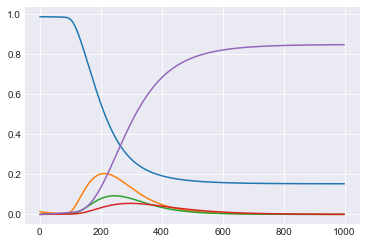

In [10]:
plt.plot(trajs[6,:,0,:])
plt.show()

In [59]:
# in tfp last dim is event samples
import tensorflow_probability as tfp
dist = tfp.distributions.Empirical(trajs, event_ndims=3)
print(dist)

tfp.distributions.Empirical("Empirical_Empirical", batch_shape=[], event_shape=[1000, 62, 5], dtype=float32)


In [60]:
dist.sample().shape

TensorShape([1000, 62, 5])

In [136]:
dist.event_shape

TensorShape([1000, 62, 5])

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors
L = 4
bc = []
for i in range(L):
    affine = tfp.bijectors.AffineScalar(shift=tf.Variable(tf.zeros_like(trajs[0])), scale=tf.Variable(tf.ones_like(trajs[0])))
    bc.append(affine)
chain = tfb.Chain(bc)

In [89]:
nvp = tfd.TransformedDistribution(
    distribution=dist,
    bijector=chain)

x = nvp.sample()
nvp.log_prob(x)
print(x.shape)



(1000, 62, 5)


In [171]:
import tensorflow.keras as tfk

class AffineBijector(tfk.layers.Layer):
    def __init__(self, dist, num_layers=1):
        super(AffineBijector, self).__init__()
        chain = []
        for L in range(num_layers):
            w = self.add_weight(
                shape=(dist.event_shape), initializer=tf.random_uniform_initializer(0.95, 1.05), trainable=True
            )
            b = self.add_weight(shape=(dist.event_shape), initializer="zeros", trainable=True)
            chain.append(tfp.bijectors.AffineScalar(shift=b, scale=w))
        self.dist = tfd.TransformedDistribution(distribution=dist, bijector=tfb.Chain(chain))
    def call(self, inputs):
        return self.dist.mean()

class ME(tfk.Model):
    def __init__(self, dist, num_layers=1):
        super(ME, self).__init__()
        self.layer = AffineBijector(dist, num_layers)
        self.dist = self.layer.dist
    def call(self, inputs):
        mean = self.layer(inputs)
        fit = (mean[500, 0, 0] - 0.5)**2
        return fit - self.dist.entropy()

model = ME(dist)


In [172]:
model.compile(optimizer=tf.optimizers.Adam(0.1), loss=lambda _, loss: loss)

In [173]:
len(model.weights)

2

In [174]:
model.evaluate([1],[1])

1/1 [==============================] - 0s 1000us/step - loss: 113.4311


113.43110656738281

In [175]:
steps = 1e4
history = model.fit(tf.range(steps), tf.range(steps))

313/313 [==============================] - 59s 188ms/step - loss: -651916.8125


In [176]:
history.history

{'loss': [-651916.8125]}

In [177]:
# try them out?
nf_trajs = model.layer.dist.sample(100)

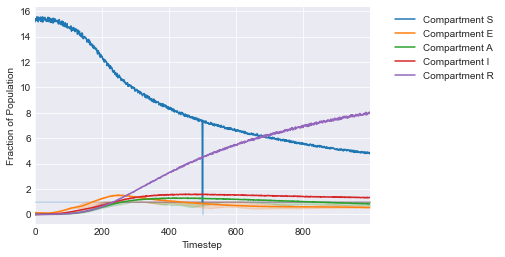

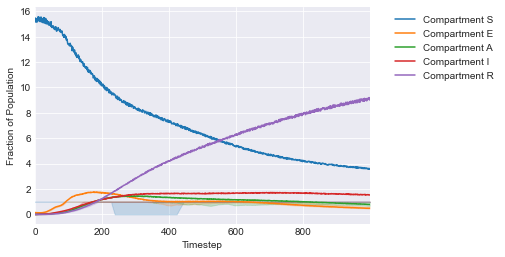

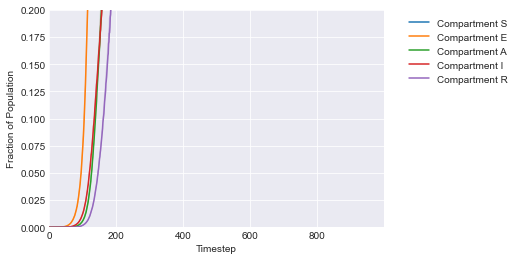

In [178]:
traj_quantile(nf_trajs[:,:,0,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(nf_trajs[:,:,1,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.show()
traj_quantile(nf_trajs[:,:,2,:], names=['S', 'E', 'A', 'I', 'R'], plot_means=True)
plt.ylim(0,0.2)
plt.show()